(Edit 3)Beginning the data collecting by loading in MNIST original, a dataset with 70,000 small images of digits. The images are 28x28 pixels, and are grayscale. The images are already split into a training set (60,000 images) and a test set (10,000 images). The labels are the digits these images represent: integers from 0 to 9.

In [43]:
from scipy.io import loadmat

mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

Once the data has been loaded in, preprocessing can begin

In [44]:
from sklearn.preprocessing import StandardScaler
import numpy as np
#preprocessing the data.  We must first reshape the data to a 4D array(samples,width,height,number of colors), where each image is a different 2D matrix
#Normalizing the values of the data, could experiment with minmax scaler too.  To do this, we must flatten the data to a 2D array, then turn it back into a 4D array
#I do not need to look for null values because this data does not have any
mnist_data = mnist_data.reshape(-1, 28, 28, 1)
mnist_data_2d = mnist_data.reshape(-1, 28*28)
scaler = StandardScaler()
mnist_data_normalized = scaler.fit_transform(mnist_data_2d)
#After the 2D data has been normalized, return it to a 4D array
mnist_data_normalized = mnist_data_normalized.reshape(-1, 28, 28, 1)

The data must be split into a testing and a training set. The training set will be used to train the model, and the testing set will be used to test the model. The testing set will be 20% of the data, and the training set will be 80% of the data.

In [45]:
from sklearn.model_selection import train_test_split
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mnist_data_normalized, mnist_label, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#print(X_train[0])

(56000, 28, 28, 1) (56000,)
(14000, 28, 28, 1) (14000,)


We have 2D representations of the matrixes, they are 28 by 28 pixels. We can visualize the data by reshaping the data into a 28 by 28 matrix, and then plotting it using matplotlib. The data of these images are normalized.

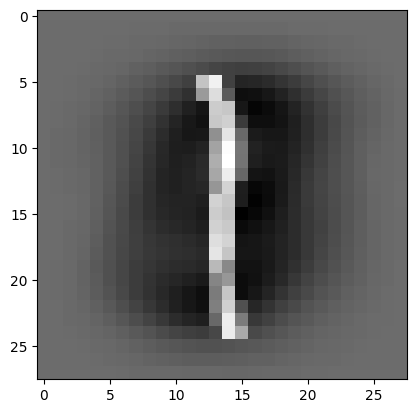

In [46]:
import matplotlib.pyplot as plt
random_nr = np.random.randint(0, 56000) #Selects random image from traning set. There are 56,000 images in traning set.

#Printing out the 2D array of the image
plt.imshow(X_train[random_nr].reshape(28,28), cmap="gray")

plt.show()

Now that we are certain the dataset is valid and ready to be used, we can now begin image augmentation. Image augmentation artificially increases the size of a dataset by modifying images by rotating and zooming them. This is done to prevent overfitting, and to make the model more robust. The images are rotated by 10 degrees, and zoomed by 10%. The images are then reshaped back into a 28 by 28 matrix.

(56000, 28, 28, 1)
(56000, 28, 28, 1)
(9, 28, 28, 1)


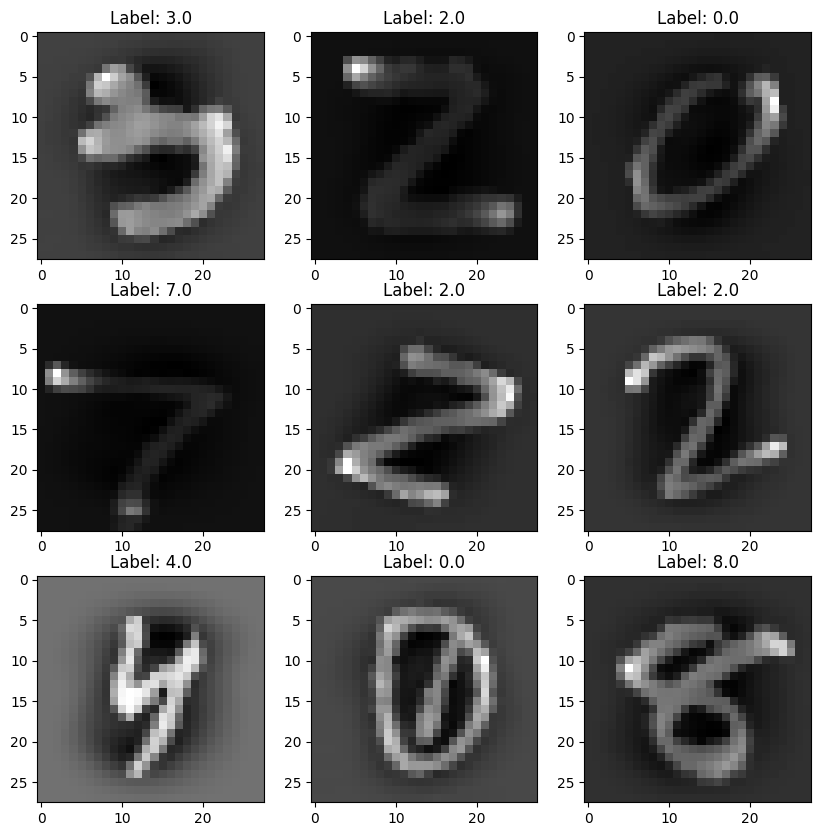

In [47]:
#Attempting to use Keras's image augmentation
import keras.preprocessing.image
from keras.preprocessing.image import ImageDataGenerator
print(format(X_train.shape))
datagen = ImageDataGenerator(
        rotation_range=25,  
        zoom_range = 0.10,  
        )
datagen.fit(X_train)
print(X_train.shape)
augmented_images, augmented_labels = next(datagen.flow(X_train, y_train, batch_size=9)) #Aumgent 9 images in random from training set
print(augmented_images.shape)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(augmented_images[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {augmented_labels[i]}")
plt.show()

We can now apply CNN model to train and evaluate our dataset. We use multiple layers shown below, and use accuracy and MAE to evaluate the model. Overall, CNN performs well.

In [49]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

# One-hot encode the labels
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Define the model architecture
model = Sequential()

#Adds a 2D convolutional layer with 32 filters of size 3x3 and add ReLU activation function to the model. 
#The input_shape argument specifies the shape of the input data.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

#2D max pooling layer to the model, which reduces the spatial dimensions of the output from the previous 
#layer by a factor of 2
model.add(MaxPooling2D((2, 2)))

#Another 2D convolutional layer with 64 filters of size 3x3 and a ReLU activation function to the model.
model.add(Conv2D(64, (3, 3), activation='relu'))

#Add another max pooling layer
model.add(MaxPooling2D((2, 2)))

#Adds another Convolution 2D layer.
model.add(Conv2D(64, (3, 3), activation='relu'))

#A flatten layer to the model, which reshapes the output of the previous layer into a one-dimensional array.
model.add(Flatten())

#A fully connected (dense) layer with 64 units and a ReLU activation function to the model.
model.add(Dense(64, activation='relu'))

#Another fully connected layer with 10 units and a softmax activation function to the model.
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", "mae"])

#Obtain the number of models parameters in total and for each layer.
print(model.summary())

print("\n\nTRAINING PHASE:")
# Train the model
history = model.fit(X_train, y_train_onehot, epochs=4, batch_size=64, validation_data=(X_test, y_test_onehot))

print("\nTESTING PHASE:")
#Get the predictions from the testing phase.
y_pred = model.predict(X_test)

# Convert predicted probabilities to predicted labels. This is b/c y_pred contians a list of probabilities for each sample.
y_pred_labels = np.argmax(y_pred, axis=1)

#Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred_labels)

macro_precision = precision_score(y_test, y_pred_labels, average="macro")
micro_precision = precision_score(y_test, y_pred_labels, average="micro")

macro_recall = recall_score(y_test, y_pred_labels, average="macro")
micro_recall = recall_score(y_test, y_pred_labels, average="micro")

macro_f1 = f1_score(y_test, y_pred_labels, average="macro")
micro_f1 = f1_score(y_test, y_pred_labels, average="micro")

mae = mean_absolute_error(y_test, y_pred_labels)

print("\nEvaluation metrics from testing phase:")
print("Accuracy: {:.4f}".format(accuracy))
print("Macro-Precision: {:.4f}".format(macro_precision))
print("Macro-Recall: {:.4f}".format(macro_recall))
print("Macro-F1-Score: {:.4f}".format(macro_f1))
print("Micro-Precision: {:.4f}".format(micro_precision))
print("Micro-Recall: {:.4f}".format(micro_recall))
print("Micro-F1-Score: {:.4f}".format(micro_f1))
print("Mean Absolute Error: {:.4f}".format(mae))




Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_21 (Flatten)        (None, 576)             